The goal of this notebook is to illustrate the idea of uncertainty propagation from the data to the model parameters.
We will also use information geometry to help us visualize this process.

To establish the notation, we will denote the observed data as $y \in \mathbb{R}^M$ and the parameterized model as $f(\theta; t)$.
$\theta \in \mathbb{R}^N$ are the parameters of the model and $t$ are the independent variables corresponding to the data.
To clarify, $M$ and $N$ represents the number of data points (and model output) and parameters, respectively.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline
plt.style.use("default")
np.random.seed(1717)

# Information geometry

Information geometry is a field that studies the geometrical structure of probability distributions [1].
In this view, a statistical model is treated as a map from a $N$ dimensional parameter space to a $M$ dimensional prediction (or data) space.
The parameter space is the domain of the mapping.
The image of the parameter space in prediction space via the model map is a $N$ dimensional model manifold embedded in a $M$ dimensional prediction space.
The model manifold thus can be thought as a generalization of column space for any model mapping.

To help illustrate this idea, follow the example below, where we will use a fractional model of the form
\begin{equation}
    f(\theta; t_m) = \frac{1}{\sum_{n=0}^{N-1} \phi(\theta_n) t_m^n + t_m^N},
\end{equation}
where
\begin{equation}
    \phi(\theta_n) = \exp(\theta_n).
\end{equation}
Let's assume we only have 2 parameters and 3 outputs for simplicity.






[1]: Smith, L. (2019, September 27). A gentle introduction to information geometry. Lewis Smith. Retrieved June 10, 2023, from https://www.robots.ox.ac.uk/~lsgs/posts/2019-09-27-info-geom.html#:~:text=In%20brief%2C%20information%20geometry%20is,and%20unexpected%20connections%20between%20them.

Note: I have a simple implementation of the linear model in `model.py`

In [2]:
from model import FractionalModel

t = np.array([0.1, 1.0, 1.1])


def transform(theta):
    """Parameter transformation function phi."""
    return np.exp(theta)


model = FractionalModel(N=2, t=t, transform=transform)

The model manifold comprises of all the prediction values that the model can make with all possible combinations of parameters.
To achieve this, we create a parameter grid and evaluate the model at every point on the grid.

In [3]:
# Generate data to plot the model manifold
params_list = np.linspace(-6, 2, 100)
P0, P1 = np.meshgrid(params_list, params_list)  # Parameter grid

PREDS = np.zeros((*P0.shape, model.M))
for ii in range(len(params_list)):
    for jj in range(len(params_list)):
        params = np.array([P0[ii, jj], P1[ii, jj]])
        PREDS[ii, jj] = model.predict(params)

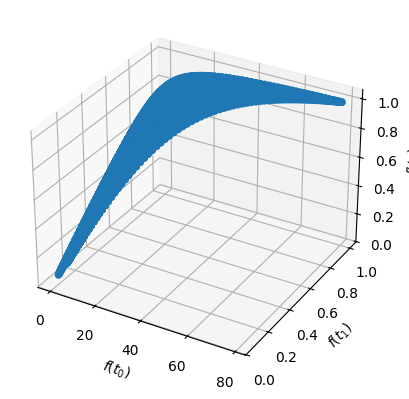

In [4]:
# Plot the model manifold
plt.figure()
ax = plt.subplot(111, projection="3d")
ax.scatter(PREDS[:, :, 0].flatten(), PREDS[:, :, 1].flatten(), PREDS[:, :, 1].flatten())
ax.set_xlabel(r"$f(t_0)$")
ax.set_ylabel(r"$f(t_1)$")
ax.set_zlabel(r"$f(t_2)$")
plt.show()

# Learning problem

In training a model to fit some observed data, we often assume that the data is related to the model by some random noise $\epsilon$,
\begin{equation}
    y_m = f(\theta^*; t_m) + \epsilon_m,
\end{equation}
where $\theta^*$ is the parameter value that best fits the data.
We will come back later on what "best fit" means.
Additionally, the noise is often assumed to be independent and distributed according to some Gaussian distribution (a consequence of the central limit theorem),
\begin{equation}
    \epsilon_m \sim \mathcal{N}(0, \sigma_m^2),
\end{equation}
where $\sigma$ is the standard deviation.
Note that the noise doesn't need to be identically distributed, i.e., they can have different standard deviations.
Equivalently, the data is assumed to be normally distributed around $f(\theta^*: t_m)$,
\begin{equation}
    y_m \sim \mathcal{N}(f(\theta^*; t_m), \sigma_m^2).
\end{equation}


This statistical view of the data gives a definition of the best fit parameters $\theta^*$ as the parameter values that are most likely to reproduce the observed data.
Let's denote the probability of the data for given parameters as $P(y|\theta)$, where in this specific case,
\begin{equation}
    P(y|\theta) \propto \exp \left( -\frac{1}{2} \sum_{m=1}^{M-1} \left( \frac{y_m - f(\theta; t_m)}{\sigma_m} \right)^2 \right).
\end{equation}
The best fit parameters are found by finding $\theta$ that correspond to the mode of $P(y|\theta)$.


Before continuing further, notice that the object $P(y|\theta)$ implies that we have a fix $\theta$ while $y$ varies.
However in our case, we have fixed data $y$ and we want to find $\theta$ that best fits the data, i.e., $\theta$ must be the varying variables.
To achieve this, we introduce the likelihood of the model, denoted by $\mathcal{L}(\theta|y)$.
Pointwise, 
\begin{equation}
    \mathcal{L}(\theta|y) = P(y|\theta).
\end{equation}
However, $\mathcal{L}(\theta|y)$ doesn't need to be normalized.


The best fit parameters are then defined as the parameters that maximize the likelihood.
Notice that maximizing the likelihood function $\mathcal{L}(\theta|y)$ is equivalent to minimizing the least-squares cost function
\begin{equation}
    C(\theta) = \frac{1}{2} \sum_{m=1}^{M-1} r_m(\theta)^2,
\end{equation}
where
\begin{equation}
    r_m(\theta) = \frac{y_m - f(\theta; t_m)}{\sigma_m}
\end{equation}
is the residual function.
This is the formulation of the learning problem that we often see, i.e. to find
\begin{equation}
    \theta^* = \underset{\theta}{\operatorname{arg min}} C(\theta).
\end{equation}

In [5]:
# Redefine the model with the data and error bars
data = np.array([10.0, 0.7, 0.7])
data_error = 0.1 * data
model = FractionalModel(
    N=2, t=t, data=data, data_error=data_error, transform=transform
)

The observed (training) data is represented by a point in prediction space.
This point doesn't need to sit on the model manifold, and this often is the case due to some random noise.

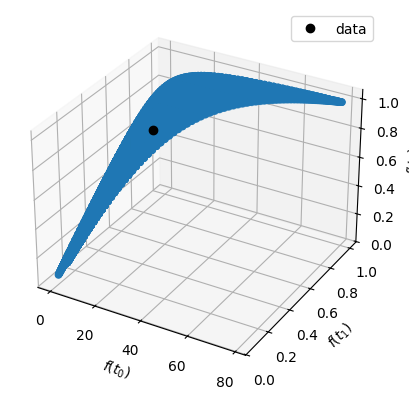

In [6]:
# Plot the data in prediction space
plt.figure()
ax = plt.subplot(111, projection="3d")
ax.scatter(PREDS[:, :, 0].flatten(), PREDS[:, :, 1].flatten(), PREDS[:, :, 1].flatten())
ax.plot(*data, "o", c="k", zorder=10, label="data")
ax.set_xlabel(r"$f(t_0)$")
ax.set_ylabel(r"$f(t_1)$")
ax.set_zlabel(r"$f(t_2)$")
plt.legend()
plt.show()

Another important object in model training and uncertainty propagation is the cost surface, which shows the cost values at all parameter values.
The cost surface is equivalent to the likelihood or log-likelihood surface.

In [7]:
# Generate cost surface data
COST = np.zeros_like(P0)
for ii in range(len(params_list)):
    for jj in range(len(params_list)):
        params = np.array([P0[ii, jj], P1[ii, jj]])
        COST[ii, jj] = model.cost(params)

In [8]:
# Train the model
import scipy.optimize as scopt

opt = scopt.least_squares(model.residual, np.zeros(model.N), method="lm")
bestfit = opt.x
print(opt)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 5.796e-03 -7.197e-01  8.986e-01]
           x: [-2.763e+00 -1.311e+00]
        cost: 0.6627336391269714
         jac: [[ 6.303e+00  2.692e+00]
               [ 5.076e-01  2.168e+00]
               [ 3.659e-01  1.719e+00]]
        grad: [ 9.116e-09 -1.049e-07]
  optimality: 1.0491659953720616e-07
 active_mask: [0 0]
        nfev: 24
        njev: None


We can see below that the best fit parameter is located at the minimum of the cost surface, by definition.

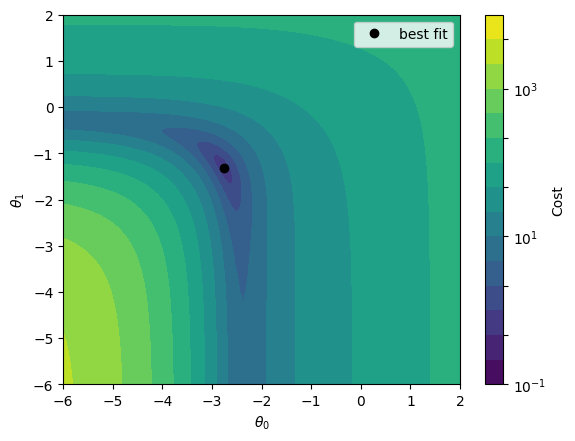

In [9]:
# Plot the cost surface
plt.figure()
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 4, 16)
)
clb = plt.colorbar(im)
plt.plot(*bestfit, "ko", label="best fit")

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.legend()
plt.show()

# Uncertainty propagation

We have assumed that the data is distributed normally, and we have incorporated this assumption into our learning problem.
This assumption also means that if we redo the data collection experiment over and over, we will not get the same exact numbers.
Instead, we will get points around the original data, which correspond to samples from the distribution of the data.
If we train the model using each of these samples, then we will get some distribution of the inferred parameters.
In a sense, the distribution of the data is propagated to the parameters.


To see this, we will generate some artificial data and use each value to train the model.
The artificial data is generated by sampling the multivariate normal distribution, centered at the original training data, with a variance of $m^{\text{th}}$ data point be $\sigma_m^2$.

In [10]:
# Generate artificial data, centered at the data we used previously in the training
ndata_ens = 10
art_data = np.random.multivariate_normal(
    model.data, cov=np.diag(model.data_error**2), size=ndata_ens
)

We then use each data sample to train our model.
Doing this, we will get a parameter ensemble.

In [11]:
# Train the model to fit each artificial data
params_ens = np.empty((ndata_ens, model.N))
for ii, dat in enumerate(art_data):
    model.data = dat
    opt = scopt.least_squares(model.residual, np.zeros(model.N), method="lm")
    params_ens[ii] = opt.x
model.data = data  # Revert the stored data to the original values

Now, let's plot the data samples and the corresponding parameter ensemble.
We will color the related points in the parameter space and prediction space with the same color.

In [12]:
# Define colors to use on the samples. This is to make correspondence between points
# in prediction space and points in parameter space.
colors = mpl.colormaps.get_cmap("bwr")(np.linspace(0, 1, ndata_ens))

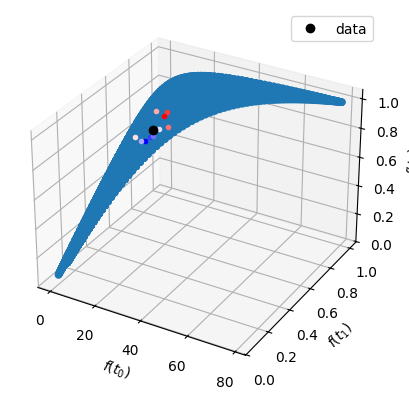

In [13]:
# Plot the data ensembles
plt.figure()
ax = plt.subplot(111, projection="3d")
# Model manifold
ax.scatter(PREDS[:, :, 0].flatten(), PREDS[:, :, 1].flatten(), PREDS[:, :, 1].flatten())

# Data samples
for ii, dat in enumerate(art_data):
    ax.plot(*dat, ".", c=colors[ii], zorder=10)
# Original data
ax.plot(*data, "ko", zorder=10, label="data")

ax.set_xlabel(r"$f(t_0)$")
ax.set_ylabel(r"$f(t_1)$")
ax.set_zlabel(r"$f(t_2)$")
plt.legend()
plt.show()

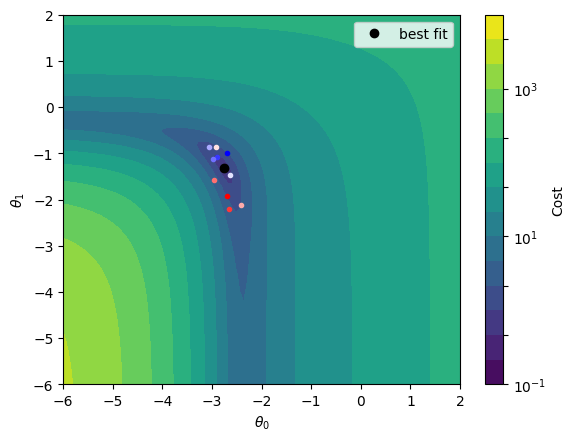

In [14]:
# Plot the parameter ensemble
plt.figure()
# Cost surface
im = plt.contourf(
    P0, P1, COST, locator=mpl.ticker.LogLocator(), levels=np.logspace(-1, 4, 16)
)
clb = plt.colorbar(im)

# Parameter ensemble
for ii, par in enumerate(params_ens):
    plt.plot(*par, ".", c=colors[ii])
# Original best fit parameters
plt.plot(*bestfit, "ko", label="best fit")

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
clb.set_label("Cost")
plt.legend()
plt.show()

Notice that the density of the parameter ensemble is related to the shape of the cost surface, since the cost surface is closely related to the likelihood of the model.
Thus, one of the goal in parametric UQ methods is to visualize the cost surface.
Additionally, we also want to quantify the shape and features of the cost surface.
These are essentially the motivation behind the UQ methods that we will look at next.